# 1. Install Dependencies and Setup

In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

# 2. Collect Images

In [3]:
import os
import time
import uuid
import cv2

In [21]:
IMAGES_PATH = os.path.join('data','images')
number_images = 80

In [10]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Create Dataset

In [8]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\22a9dcc1-077a-11ef-ad6d-d89c6703550e.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[209, 186, 194],
        [210, 187, 195],
        [211, 188, 196],
        ...,
        [ 36,  24,  12],
        [ 40,  23,  15],
        [ 41,  24,  17]],

       [[210, 187, 195],
        [211, 188, 196],
        [212, 189, 197],
        ...,
        [ 38,  24,  11],
        [ 42,  25,  15],
        [ 43,  26,  18]],

       [[211, 188, 196],
        [212, 189, 197],
        [212, 189, 197],
        ...,
        [ 37,  24,   8],
        [ 40,  24,  11],
        [ 42,  26,  13]],

       ...,

       [[ 85,  81,  69],
        [ 86,  82,  70],
        [ 84,  80,  69],
        ...,
        [ 77,  75,  80],
        [ 78,  76,  79],
        [ 81,  79,  82]],

       [[ 86,  79,  69],
        [ 85,  81,  70],
        [ 83,  79,  70],
        ...,
        [ 74,  74,  76],
        [ 75,  73,  76],
        [ 80,  78,  81]],

       [[ 87,  80,  70],
        [ 88,  81,  71],
        [ 83,  78,  72],
        ...,
        [ 74,  74,  76],
        [ 74,  72,  75],
        [ 79,  77,  80]]

In [19]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

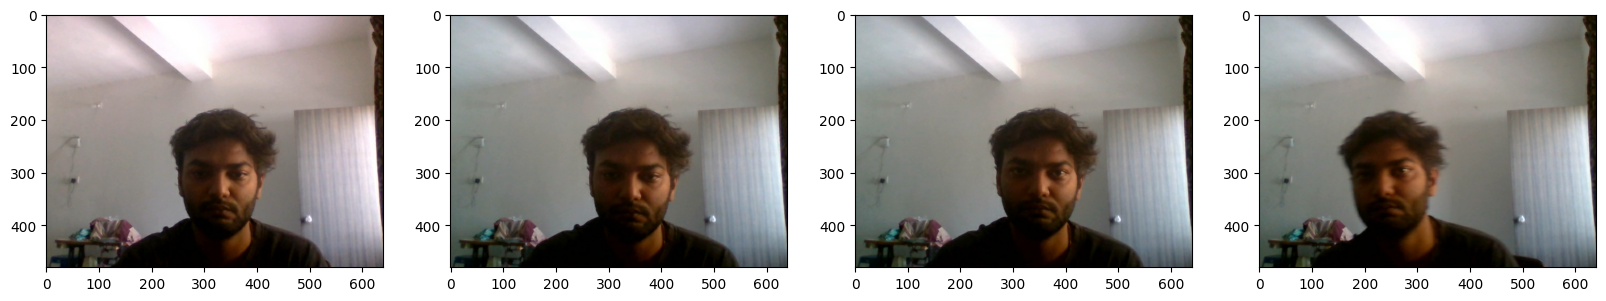

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()    

In [22]:
80*0.7

56.0

In [24]:
80*.15

12.0

# 4. Move Matching Labels AFTER Annotation with Labelme

In [25]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('Data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('Data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('Data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# 5. Image Augmentation

In [26]:
import albumentations as alb

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [28]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('Data', partition, 'images')):
        img = cv2.imread(os.path.join('Data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('Data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='LeftEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='RightEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='LeftEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='RightEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['LeftEye','RightEye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'LeftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'RightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
